In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

import seaborn as sns

# Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`

In [2]:
db_config = {
    'user': '', # имя пользователя
    'pwd': '', # пароль
    'host': '',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [4]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date::date)::date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date::date)=2008
GROUP BY month_date
ORDER BY total_views DESC;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


В таблице видно, что просмотры постов существенно падают в летом и в декабре. Вероятно, это связано с сезонами отпусков и праздниками.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [5]:
# напишите запрос
query = '''
SELECT u.display_name AS display_name,
       COUNT(DISTINCT p.user_id) AS count 
FROM stackoverflow.users AS u
INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id
INNER JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE pt.type = 'Answer' AND
      (DATE_TRUNC('day', p.creation_date) >= DATE_TRUNC('day', u.creation_date) AND 
       DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month')
GROUP BY display_name
HAVING COUNT(pt.type) > 100
ORDER BY display_name;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Одному имени пользователя может соответсвовать несколько пользователей с разным `user_id`. Поэтому группировка по отображаемому имени пользователя не всегда бывает корректной, поскольку объединяются данные разных пользователей.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month,
       COUNT(*)
FROM stackoverflow.posts
WHERE user_id IN (SELECT DISTINCT u.id
                  FROM stackoverflow.users u
                  JOIN stackoverflow.posts p ON u.id = p.user_id
                  WHERE DATE_TRUNC('month', u.creation_date) = '2008-09-01' AND
                        DATE_TRUNC('month', p.creation_date) = '2008-12-01')
GROUP BY month
ORDER BY month DESC;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


В базе данных подозрительно мало информациии об августе 2008 года. Скорее всего, при выгрузке данных произошла техническая ошибка.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [7]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [8]:
# напишите запрос
query = '''
WITH t1 AS
  (SELECT user_id,
          DATE_TRUNC('day', creation_date) AS day,
          COUNT(DATE_TRUNC('day', creation_date)) AS posts_count
   FROM stackoverflow.posts
   WHERE DATE_TRUNC('day', creation_date) >= '2008-08-01' AND
         DATE_TRUNC('day', creation_date) <= '2008-08-31' AND 
         user_id IN (SELECT user_id
                     FROM stackoverflow.posts   
                     WHERE DATE_TRUNC('day', creation_date) >= '2008-08-01' AND
                           DATE_TRUNC('day', creation_date) <= '2008-08-31'
                     GROUP BY user_id
                     HAVING COUNT(user_id) > 120)
   GROUP BY user_id, day)
SELECT user_id,
       AVG(posts_count) AS avg_daily
FROM t1
GROUP BY user_id
ORDER BY avg_daily;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [9]:
# напишите запрос
query = '''
WITH post AS
    (SELECT user_id, 
            COUNT(DISTINCT DATE_TRUNC('day', creation_date)) as count_day
     FROM stackoverflow.posts
     WHERE DATE_TRUNC('day', creation_date) >= '2008-12-01' AND 
           DATE_TRUNC('day', creation_date) <= '2008-12-07' 
     GROUP BY user_id)
SELECT ROUND(AVG(count_day)) as result
FROM post;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,result
0,2.0


В среднем с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой 2 дня. 

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [10]:
# напишите запрос
query = '''
WITH t1 AS
    (SELECT user_id, 
            creation_date,
            LAG(DATE_TRUNC('month', creation_date), 2) OVER (PARTITION BY user_id ORDER BY creation_date) as second_month
     FROM stackoverflow.posts
     ORDER BY user_id, creation_date)
SELECT user_id, 
       creation_date,
       CASE
            WHEN EXTRACT(MONTH FROM second_month) = 1 THEN 'January'
            WHEN EXTRACT(MONTH FROM second_month) = 2 THEN 'February'
            WHEN EXTRACT(MONTH FROM second_month) = 3 THEN 'March'
            WHEN EXTRACT(MONTH FROM second_month) = 4 THEN 'April'
            WHEN EXTRACT(MONTH FROM second_month) = 5 THEN 'May'
            WHEN EXTRACT(MONTH FROM second_month) = 6 THEN 'June'
            WHEN EXTRACT(MONTH FROM second_month) = 7 THEN 'July'
            WHEN EXTRACT(MONTH FROM second_month) = 8 THEN 'August'
            WHEN EXTRACT(MONTH FROM second_month) = 9 THEN 'September'
            WHEN EXTRACT(MONTH FROM second_month) = 10 THEN 'October'
            WHEN EXTRACT(MONTH FROM second_month) = 11 THEN 'November'
            WHEN EXTRACT(MONTH FROM second_month) = 12 THEN 'December'
       END AS second_last_month
FROM t1;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [11]:
# напишите запрос
query = '''
WITH pr AS
    (SELECT u.id AS user_id,
            DATE_TRUNC('month', MIN(p.creation_date))::date AS cohort_dt,
            COUNT(u.id) OVER (PARTITION BY DATE_TRUNC('month', MIN(p.creation_date))::date) AS cohort_users_cnt 
     FROM stackoverflow.users AS u
     JOIN stackoverflow.posts AS p ON p.user_id=u.id
     GROUP BY 1), 
s AS
    (SELECT DISTINCT pr.user_id AS user_id,
            DATE_TRUNC('month', p.creation_date)::date AS session_date
     FROM pr
     JOIN stackoverflow.posts AS p ON p.user_id = pr.user_id)
SELECT pr.cohort_dt AS cohort_dt,
       s.session_date AS session_date,
       COUNT(s.user_id) AS users_cnt,
       pr.cohort_users_cnt AS cohort_users_cnt,
       ROUND((COUNT(s.user_id) * 100.0 / pr.cohort_users_cnt), 2) AS retention_rate
FROM pr
JOIN s ON pr.user_id = s.user_id
GROUP BY cohort_dt, session_date, cohort_users_cnt;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


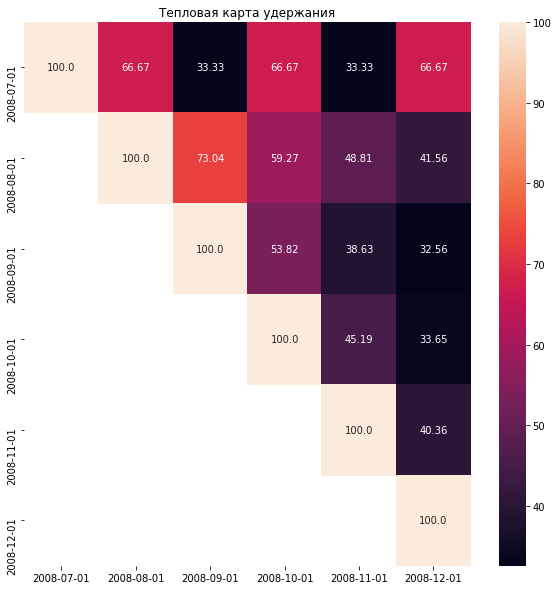

In [12]:
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]


plt.figure(figsize=(10, 10))
sns.heatmap(retention, annot=True, fmt='')
plt.title('Тепловая карта удержания')
plt.show()

На тепловой карте видно, что удержание пользователей из когорты июля 2008 года не планомерно снижается, а то снижается, то растет до прежних значений. Вероятно, это связано с техническими проблемами при сохранении данных от этих пользователей. 

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [13]:
# напишите запрос
query = '''
WITH t1 AS
    (SELECT DISTINCT EXTRACT(MONTH FROM p.creation_date::date)::integer AS creation_month,
            COUNT(*) OVER (PARTITION BY EXTRACT(MONTH FROM p.creation_date::date)) AS posts_count
    FROM stackoverflow.posts AS p
    WHERE p.creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
)
SELECT *,
       ROUND((posts_count::numeric/LAG(posts_count) OVER (ORDER BY creation_month) - 1) * 100, 2) AS percentage
FROM t1
ORDER BY creation_month;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


(-1.1113450333821804,
 1.1005402602007526,
 -1.1194443395301965,
 1.1127112873136231)

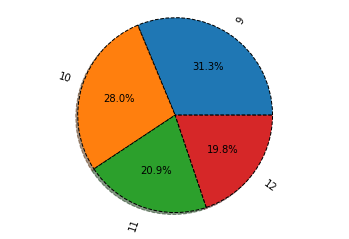

In [14]:
fig, ax = plt.subplots()
ax.pie(df['posts_count'], labels=df['creation_month'], autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal")

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [15]:
# напишите запрос
query = '''
WITH t1 AS 
    (SELECT DISTINCT user_id,
            COUNT(id)
     FROM stackoverflow.posts
     GROUP BY user_id),
t2 AS (SELECT user_id
       FROM t1
       WHERE count = (SELECT MAX(count) FROM t1))
SELECT DISTINCT EXTRACT(WEEK FROM creation_date::date)::integer AS week_creation,
       MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date::date)) AS creation_date
FROM stackoverflow.posts AS p
JOIN t2 ON p.user_id=t2.user_id
WHERE creation_date::date BETWEEN '2008-10-01' AND '2008-10-31';
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine) 
df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
